# ch6.1 最適化関数

---

## パラメータの更新
各ノードの持つ最適な重みパラメータを効率的に求めるために，様々な手法が存在する．  これらの手法は，**最適化関数(optimizer)**と呼ばれる．
### SGD (確率的勾配降下法)
これまで用いてきたパラメータの更新関数は，** SGD(確率的勾配降下法) ** と呼ばれる．

\begin{equation}
    \mathbf{W} \leftarrow \mathbf{W} - \eta \frac{\partial L}{\partial \mathbf{W}}
\end{equation}

学習係数 $\eta$ に損失関数の勾配を掛けた値でパラメータ $\mathbf{W}$ を更新する．

In [1]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

---

### Momentum
**Momentum** は運動量の意味であり，物理法則的な動きをする．

\begin{equation}
    \mathbf{v} \leftarrow \alpha \mathbf{v} - \eta \frac{\partial L}{\partial \mathbf{W}} \\
    \mathbf{W} \leftarrow \mathbf{W} + \mathbf{v}
\end{equation}

新たに変数 $\mathbf{v}$ を使う． $\mathbf{v}$ は速度の意味を持ち，数値を保持する．$\alpha$ は徐々に減速させるための変数である．  

In [2]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

---

### AdaGrad
**Adagrad**は，学習が進むに連れて学習係数を小さくする手法である．

\begin{equation}
    \mathbf{h} \leftarrow \mathbf{h} + \frac{\partial L}{\partial \mathbf{W}} \odot \frac{\partial L}{\partial \mathbf{W}} \\
    \mathbf{W} \leftarrow \mathbf{W} - \eta \frac{1}{\sqrt{\mathbf{h}}} \frac{\partial L}{\partial \mathbf{W}}
\end{equation}

$\mathbf{h}$ は，損失関数の勾配の2乗和として保持される．パラメータ更新ごとに，$\frac{1}{\sqrt{\mathbf{h}}}$を掛ける．  
大きく更新された要素は，学習係数が小さくなる．

In [3]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

---

### Adam
**Adam**は，MomentumとAdaGradを融合したような手法である．2つを組み合わせたことにより，効率的なパラメータの探索と，ハイパーパラメータのバイアス補正が実現されている．

In [4]:
class Adam:

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

それぞれの最適化関数によるパラメータ更新の様子を，3次元関数を用いて比較する．

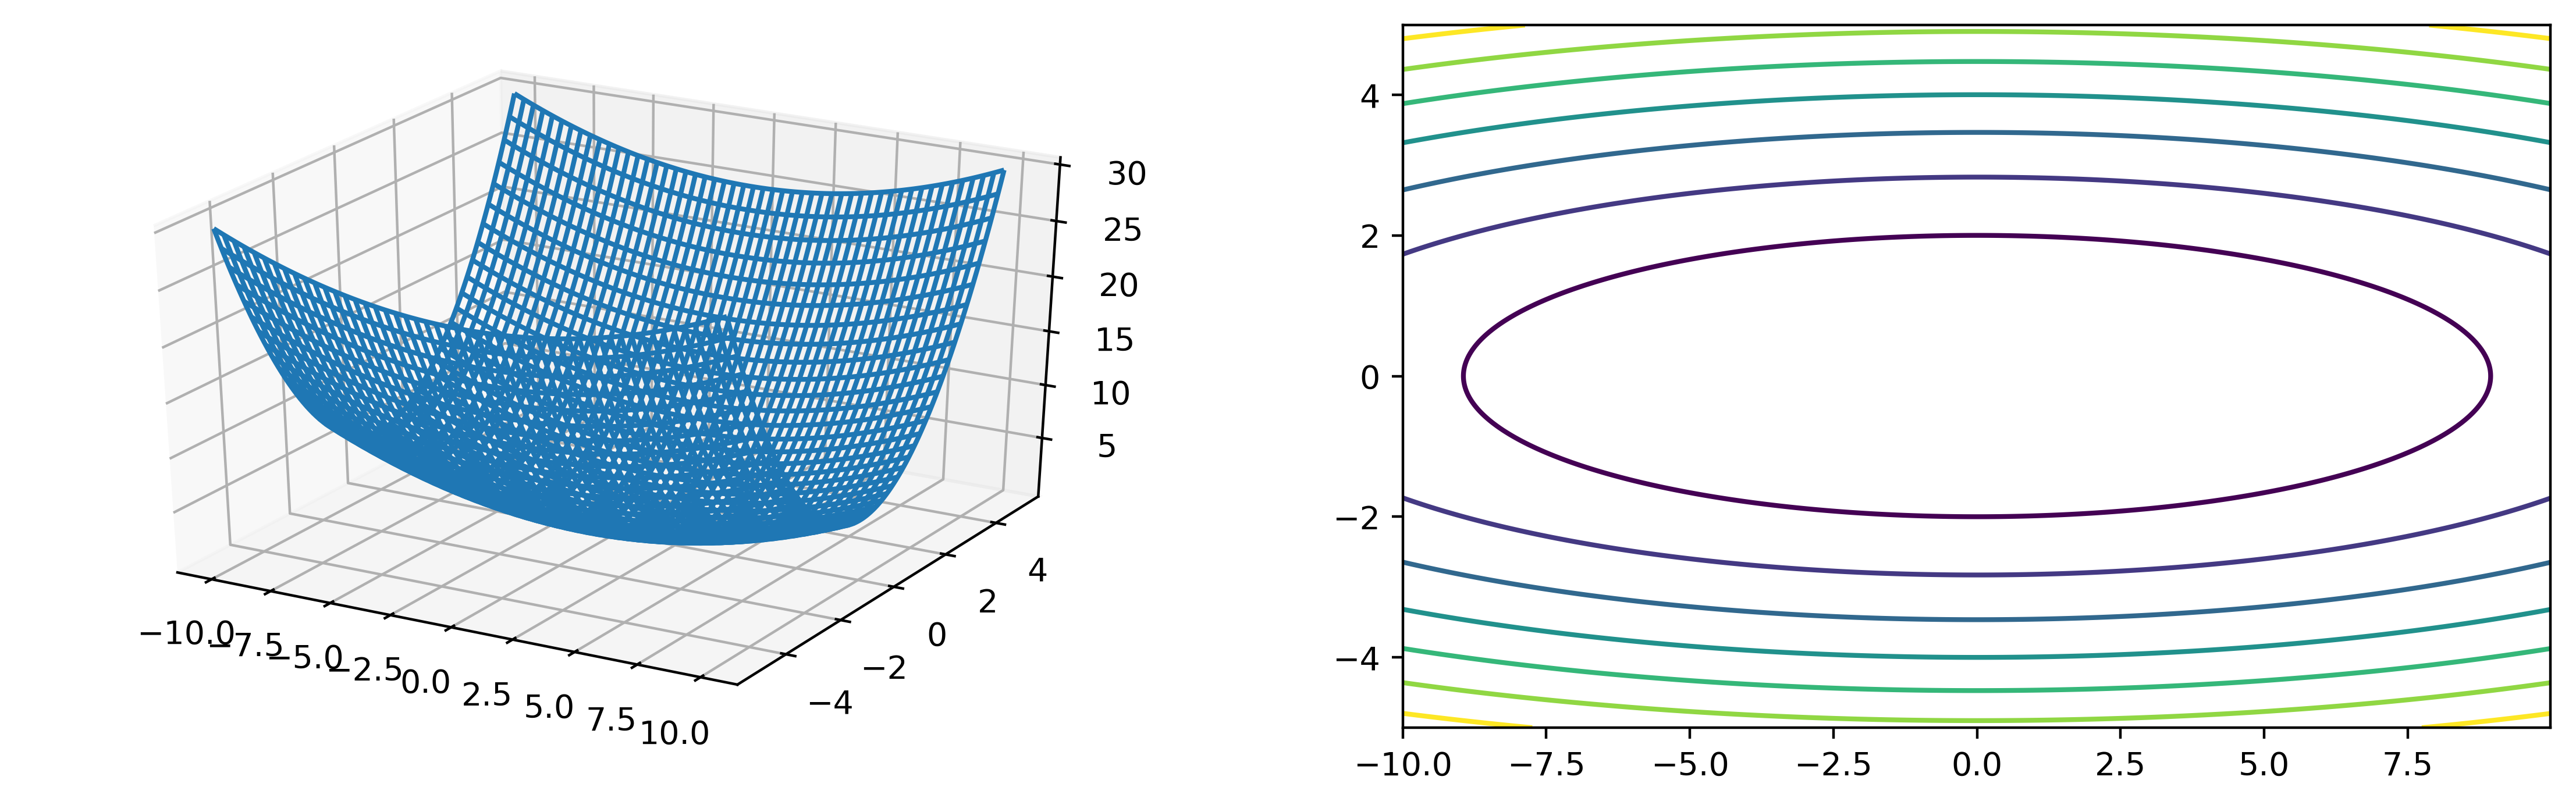

In [5]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['figure.figsize'] = (14, 4)
plt.rcParams['figure.dpi'] = 200

def f(x, y):
    return x**2 / 20.0 + y**2

x = np.arange(-10, 10, 0.01)
y = np.arange(-5, 5, 0.01)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_wireframe(X, Y, Z)

plt.subplot(1, 2, 2)
plt.contour(X, Y, Z)

plt.show()

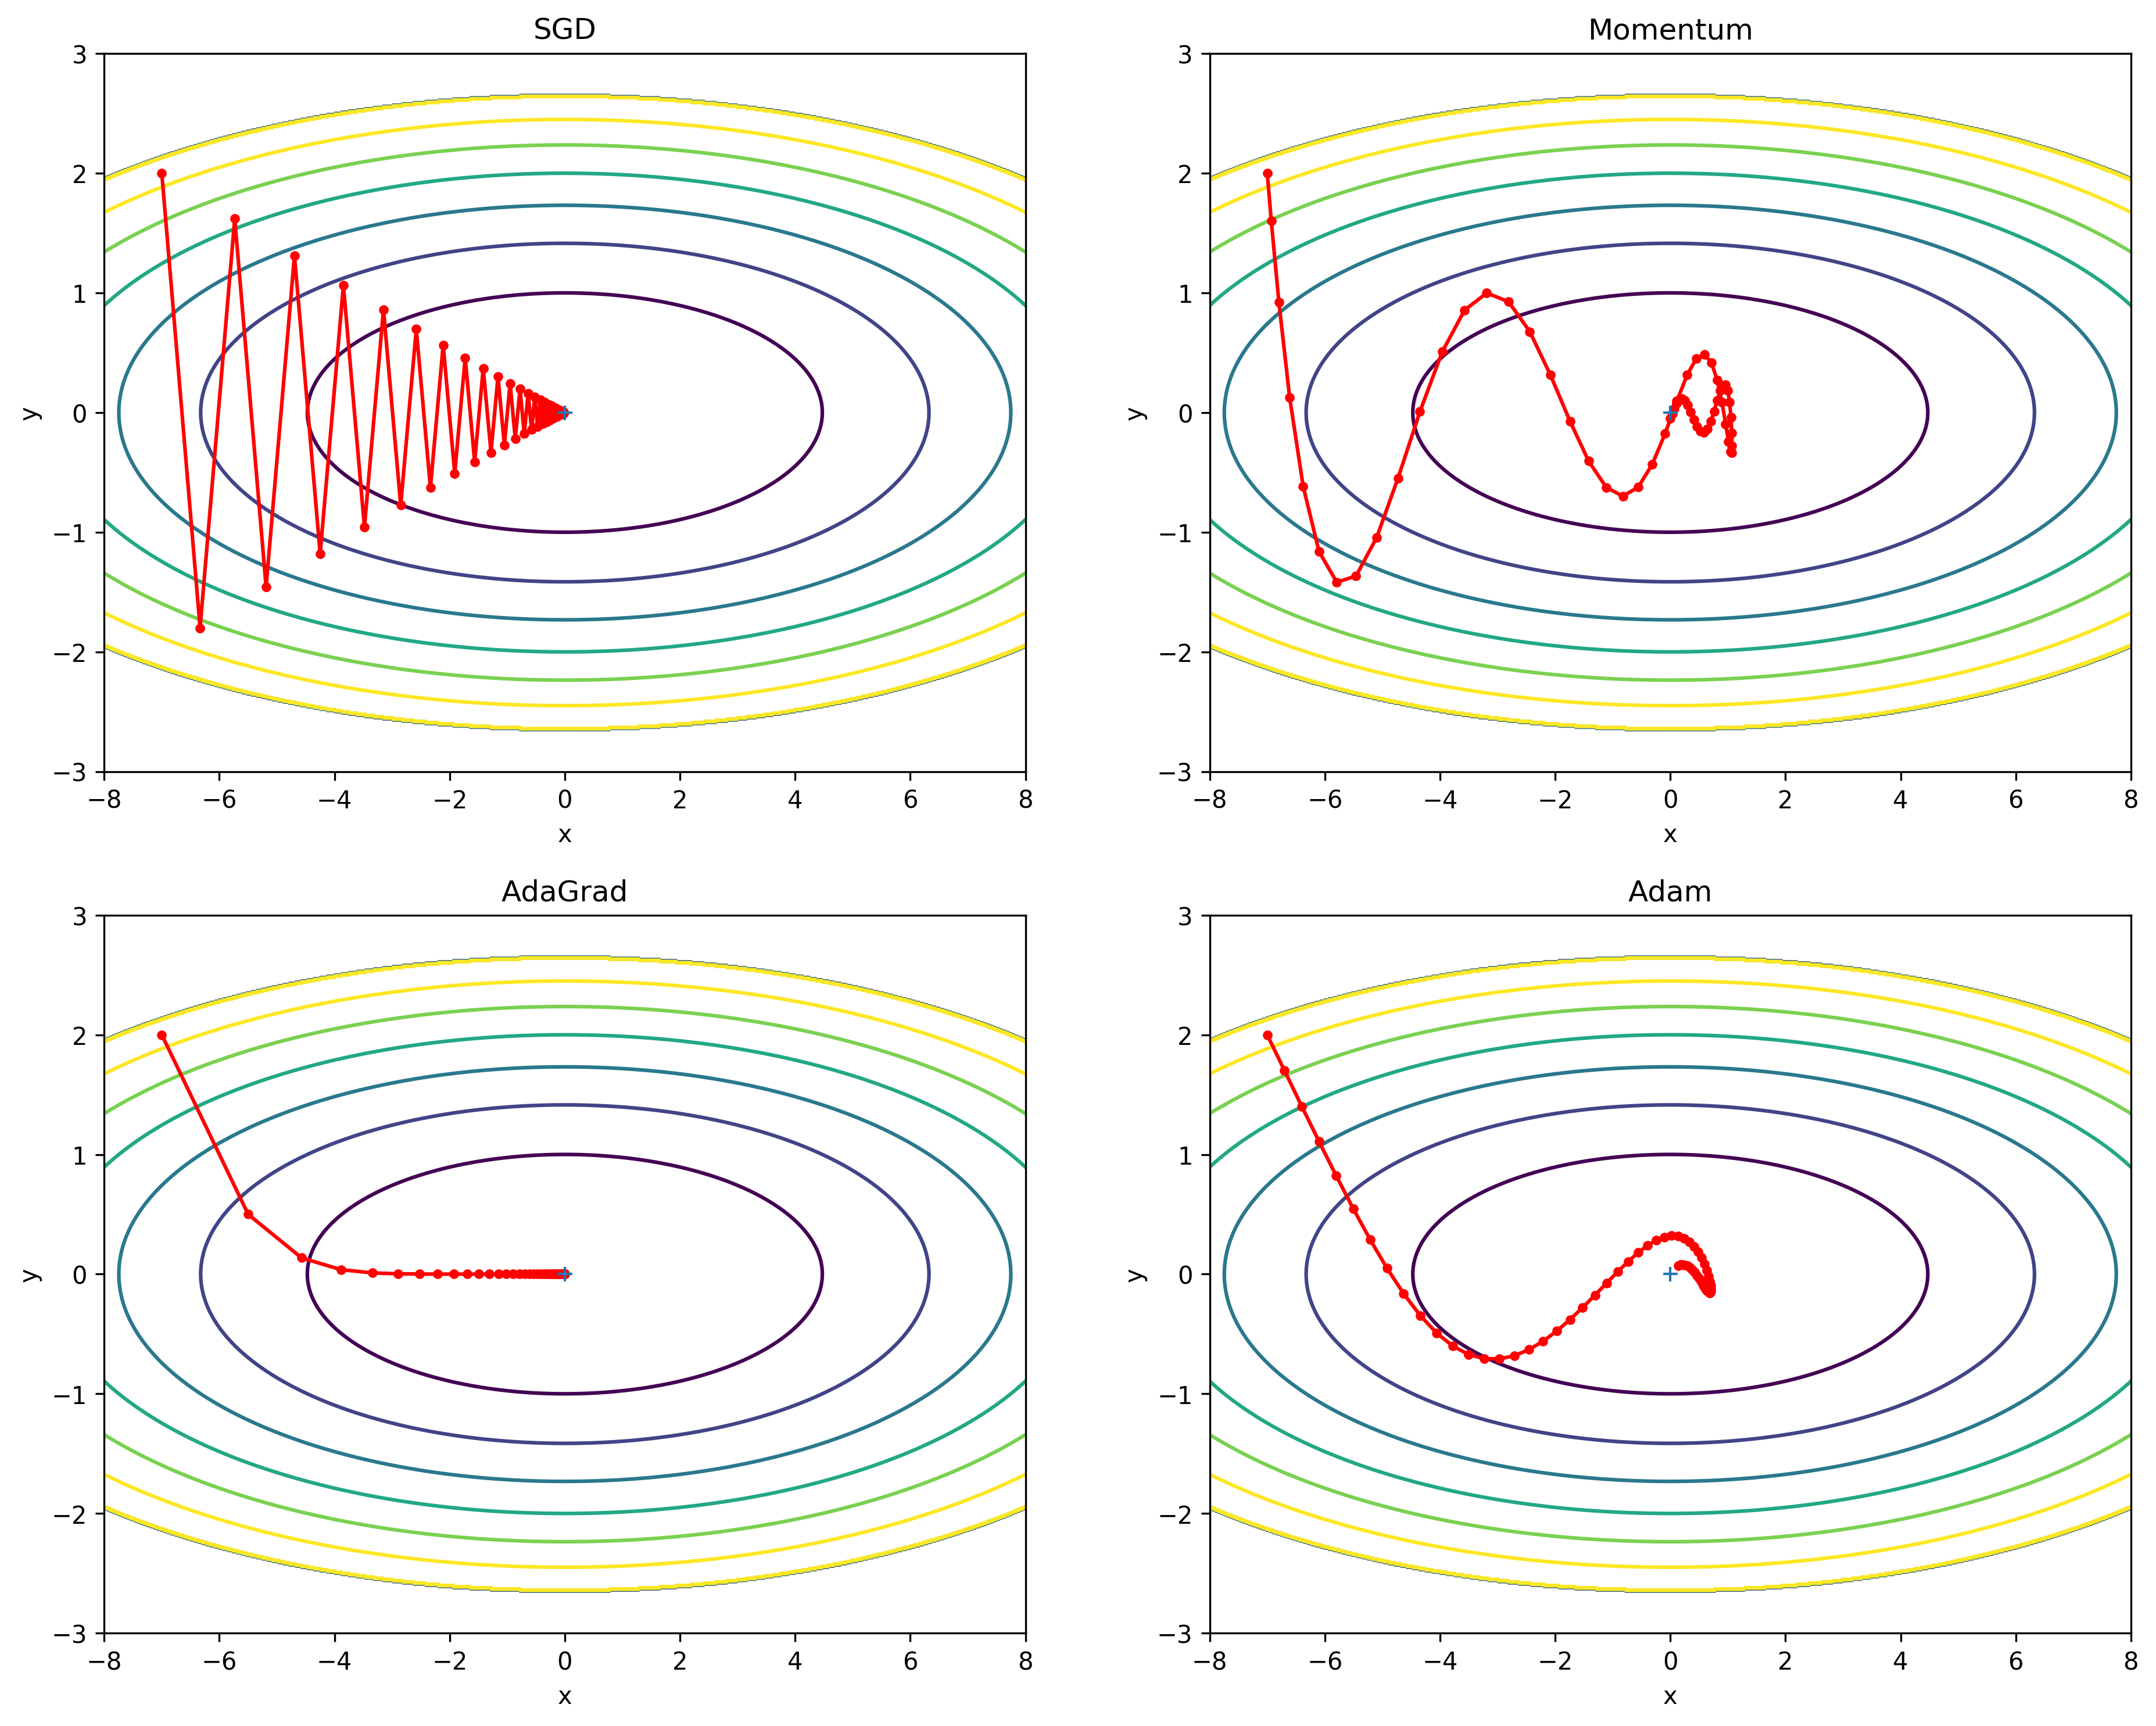

In [6]:
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['figure.dpi'] = 150

def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0

optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

for idx, key in enumerate(optimizers):
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(60):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    plt.subplot(2, 2, idx+1)
    plt.plot(x_history, y_history, '.-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-3, 3)
    plt.xlim(-8, 8)
    plt.plot(0, 0, '+')
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

他の関数で実行してみる

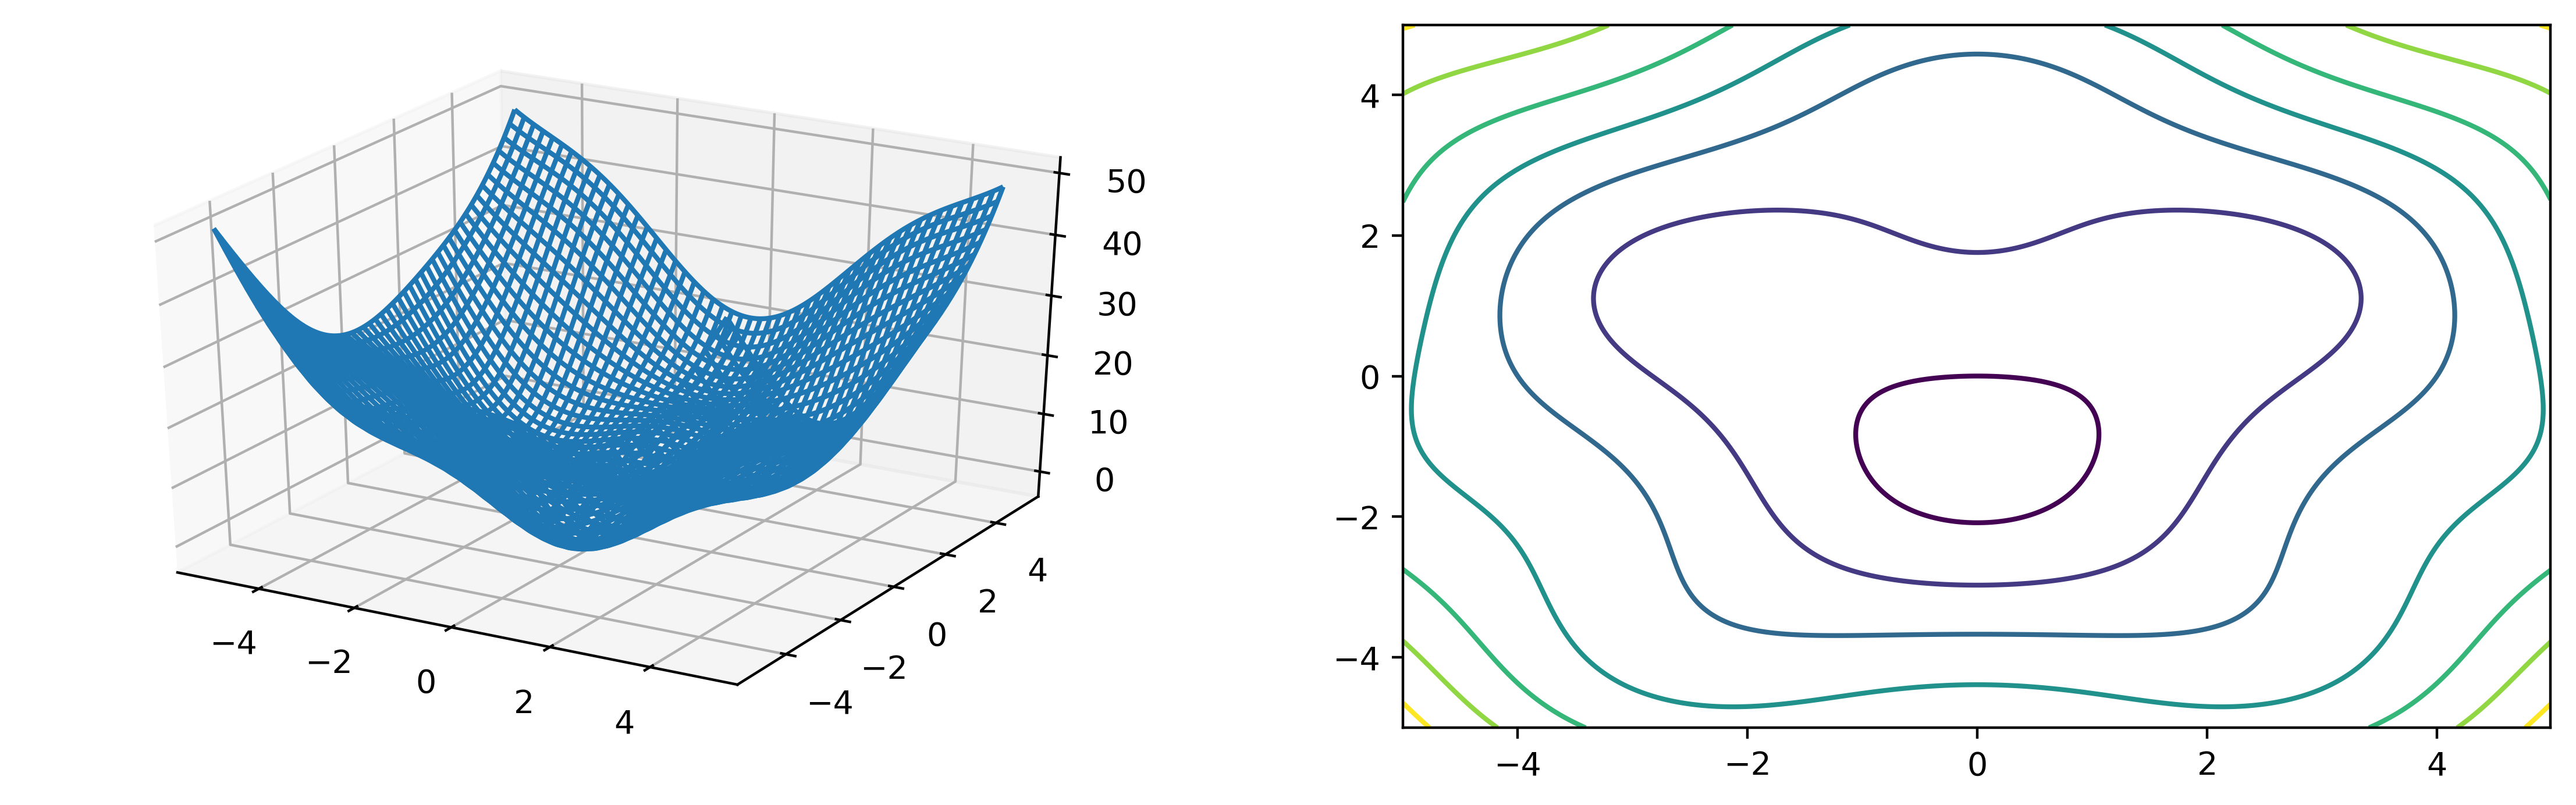

In [7]:
plt.rcParams['figure.figsize'] = (14, 4)
plt.rcParams['figure.dpi'] = 200

def f2(x, y):
    return x ** 2 + y ** 2 + np.cos(x) * np.sin(y) * 5

x = np.arange(-5, 5, 0.01)
y = np.arange(-5, 5, 0.01)
X, Y = np.meshgrid(x, y)
Z = f2(X, Y)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_wireframe(X, Y, Z)

plt.subplot(1, 2, 2)
plt.contour(X, Y, Z)

plt.show()

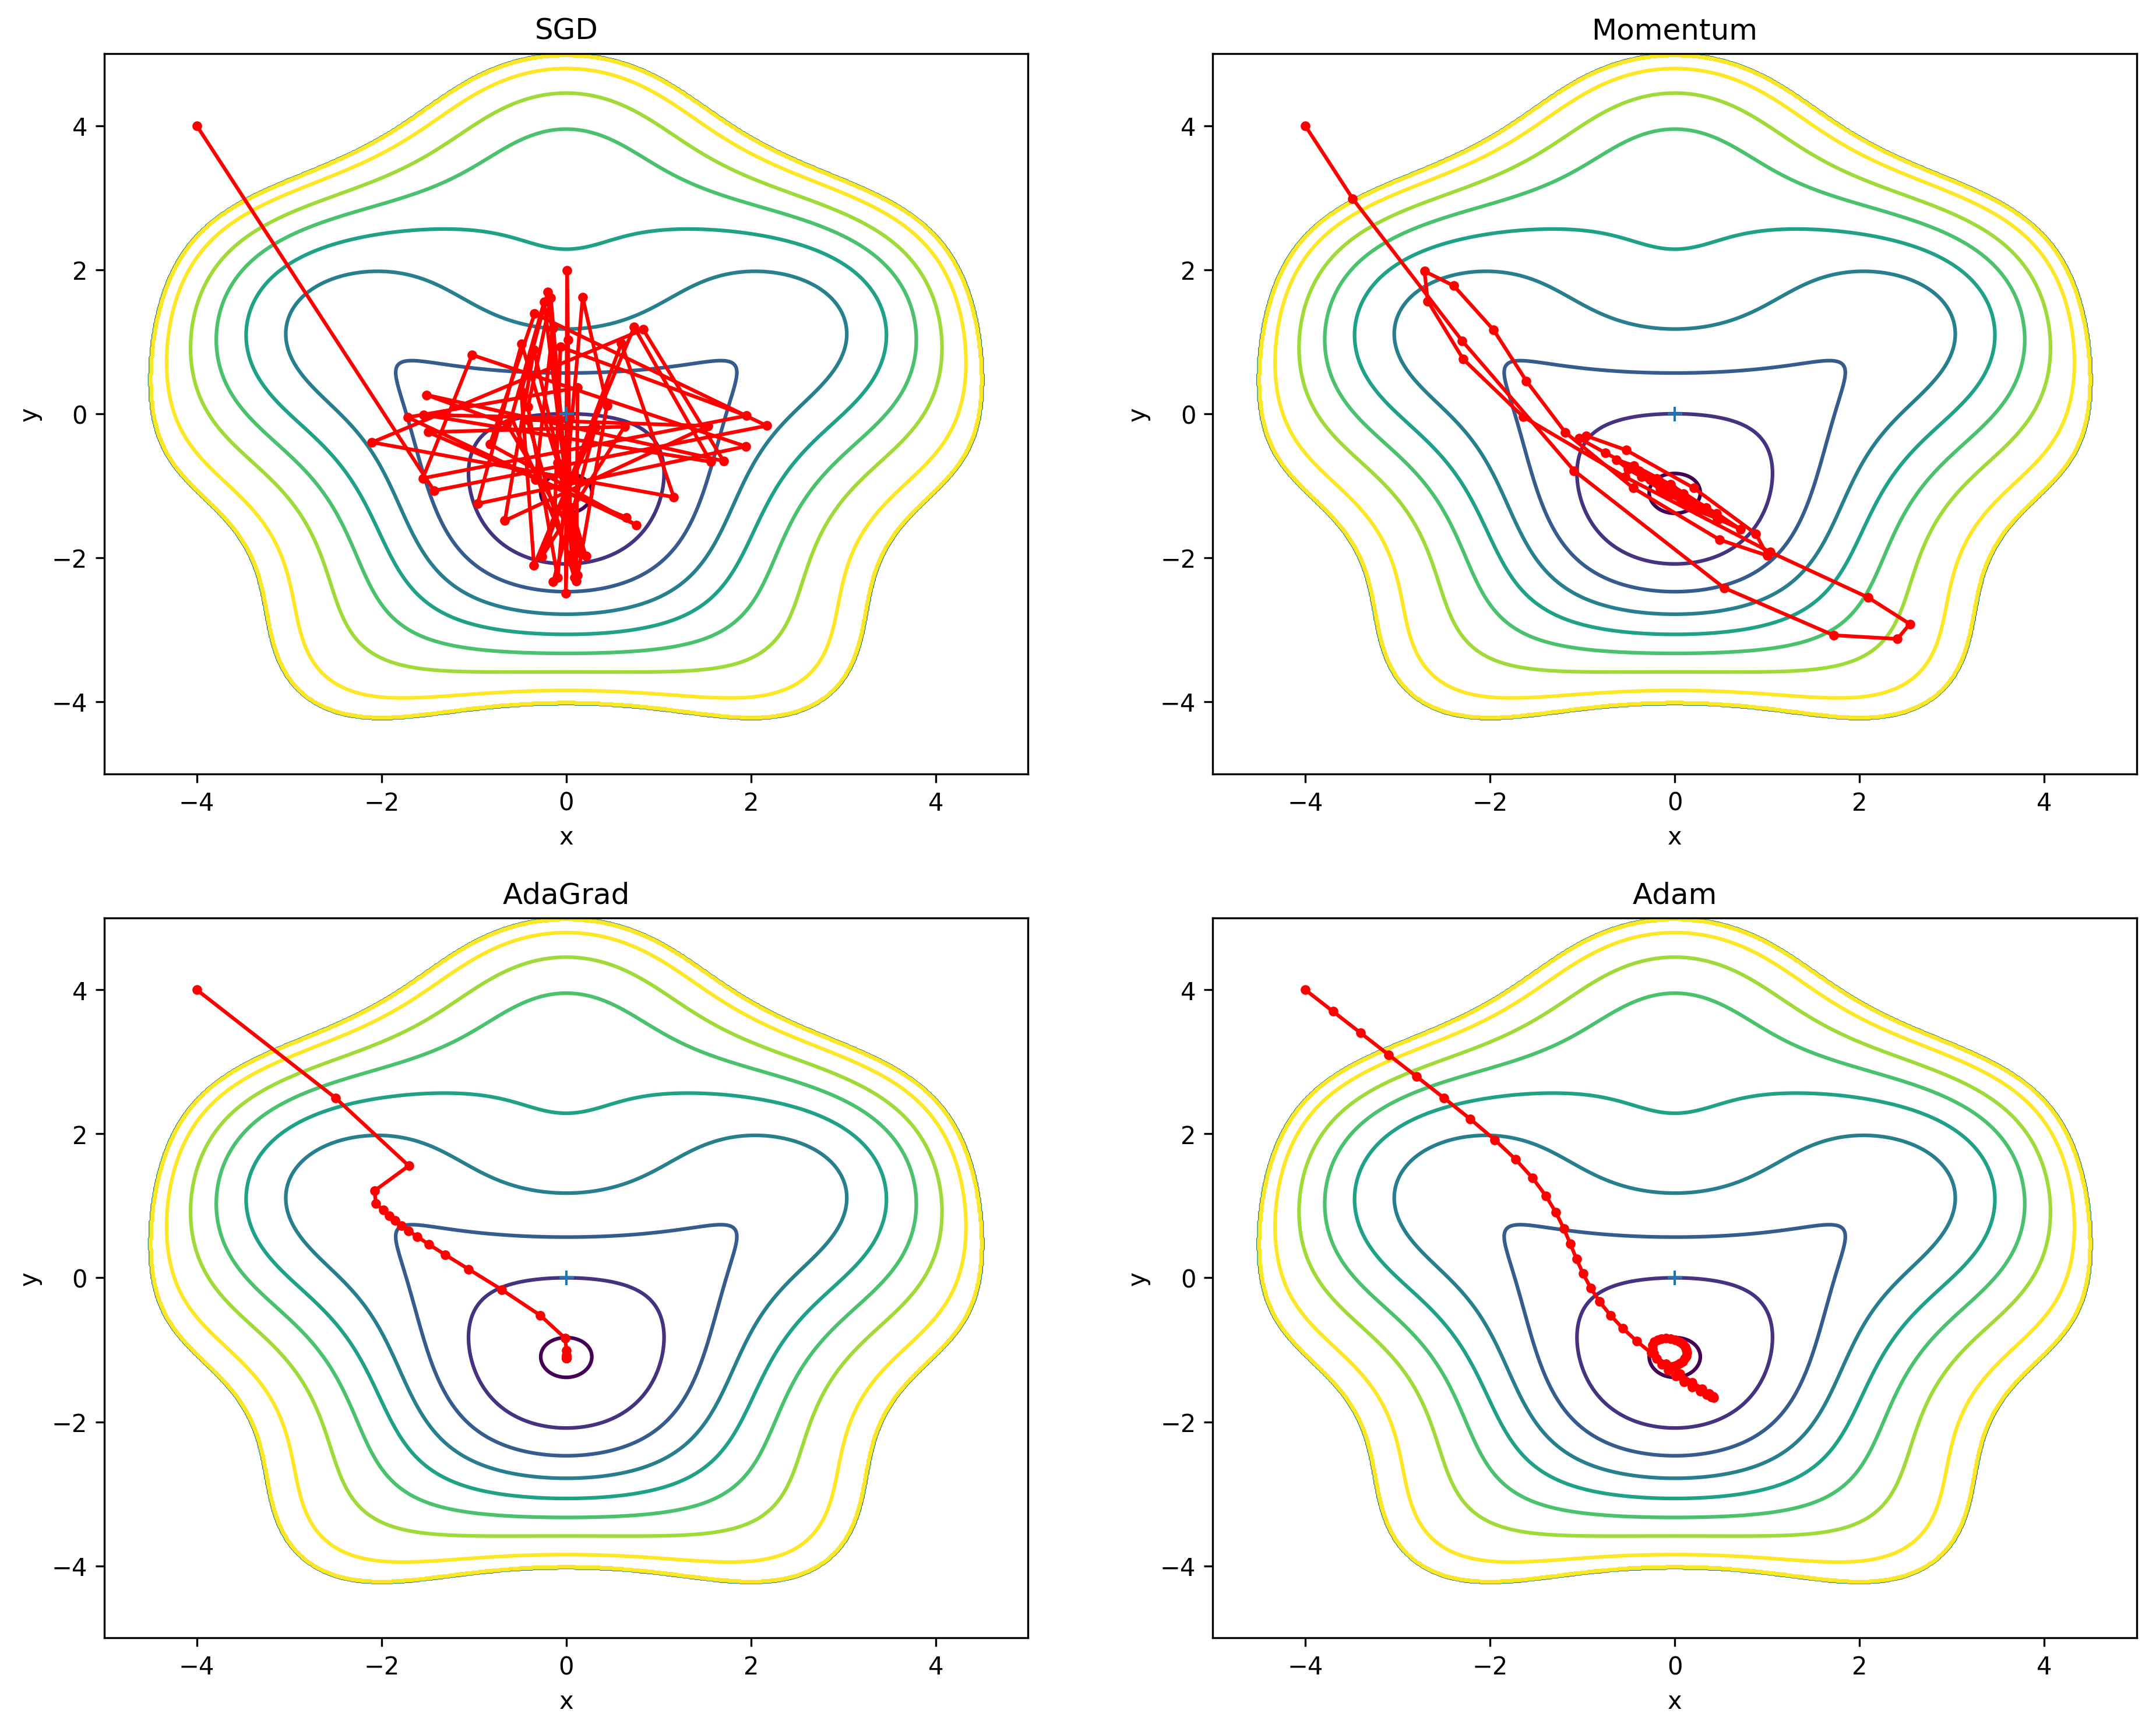

In [8]:
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['figure.dpi'] = 150

def df2(x, y):
    return x*2 - np.sin(x)*np.sin(y)*5, y*2 + np.cos(x)*np.cos(y)*5

init_pos = (-4.0, 4.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0

optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.5)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

for idx, key in enumerate(optimizers):
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(60):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df2(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-5, 5, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f2(X, Y)
    
    # for simple contour line  
    mask = Z > 20
    Z[mask] = 0
    
    plt.subplot(2, 2, idx+1)
    plt.plot(x_history, y_history, '.-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-5, 5)
    plt.xlim(-5, 5)
    plt.plot(0, 0, '+')
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

---

MNISTデータセットで，それぞれの最適化関数を用いた場合の損失関数の値をプロットする．

In [9]:
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100], output_size=10)
    train_loss[key] = []    


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

# 3.グラフの描画==========
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['figure.dpi'] = 100

markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()